# Prepare the Environment

In [ ]:
!git clone https://github.com/mhamilton723/STEGO.git

In [ ]:
!pip install gdown
!pip install wget
!pip install torchmetrics
!pip install hydra-core
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install omegaconf
!pip install pytorch-lightning
!pip install rembg

In [ ]:
!gdown 1-vslrcATiMByEqSUewN_yalFwXPpAEuP

In [ ]:
import os
import zipfile


zip_ref = zipfile.ZipFile("./train_accessories.zip", 'r')
zip_ref.extractall("STEGO/src/")
zip_ref.close()

os.remove("train_accessories.zip")

In [ ]:
import shutil


os.chdir("STEGO")
shutil.rmtree("results")
os.remove("LICENSE")
os.remove("README.md")
os.remove("environment.yml")

In [ ]:
os.chdir("src")
shutil.rmtree("configs")
shutil.rmtree("picie")
os.remove("STEGO_Colab_Demo.ipynb")
os.remove("__init__.py")
os.remove("crop_datasets.py")
os.remove("demo_segmentation.py")
os.remove("download_datasets.py")
os.remove("download_models.py")
os.remove("eval_segmentation.py")
os.remove("plot_dino_correspondence.py")
os.remove("plot_potsdam.py")
os.remove("plot_pr_curves.py")
os.remove("precompute_knns.py")
os.remove("train_crf.py")

# Import Libraries

In [1]:
import os
from os.path import join
import wget
import numpy as np
from PIL import Image
from rembg import remove
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

c:\Users\Admin\anaconda3\envs\eigenfaces\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download Pretrained Model



In [2]:
os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

In [3]:
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

# Load pretrained STEGO

In [4]:
from train_segmentation import LitUnsupervisedSegmenter


model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

c:\Minh\Programming\Projects\face-recognition-with-accessories-using-eigenfaces\STEGO\src\train_segmentation.py:386: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")


Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


c:\Users\Admin\anaconda3\envs\eigenfaces\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


# Remove Background

In [5]:
data_dir = 'train_accessories'
processed_data_dir = 'train_accessories_processed'

os.makedirs(processed_data_dir, exist_ok=True)

face_fnames = []

for person in os.listdir(data_dir):
  person_dir = os.path.join(data_dir, person)
  processed_person_dir = os.path.join(processed_data_dir, person)

  os.makedirs(processed_person_dir, exist_ok=True)

  for img_name in os.listdir(person_dir):
    img_path = os.path.join(person_dir, img_name)
    processed_img_path = os.path.join(processed_person_dir, img_name)

    image = Image.open(img_path)

    if img_name != 'damien5.jpg' and img_name != 'ricardo0.jpg':
      image = remove(image).convert('RGB')

    image.save(processed_img_path)
    
    face_fnames.append(processed_img_path)

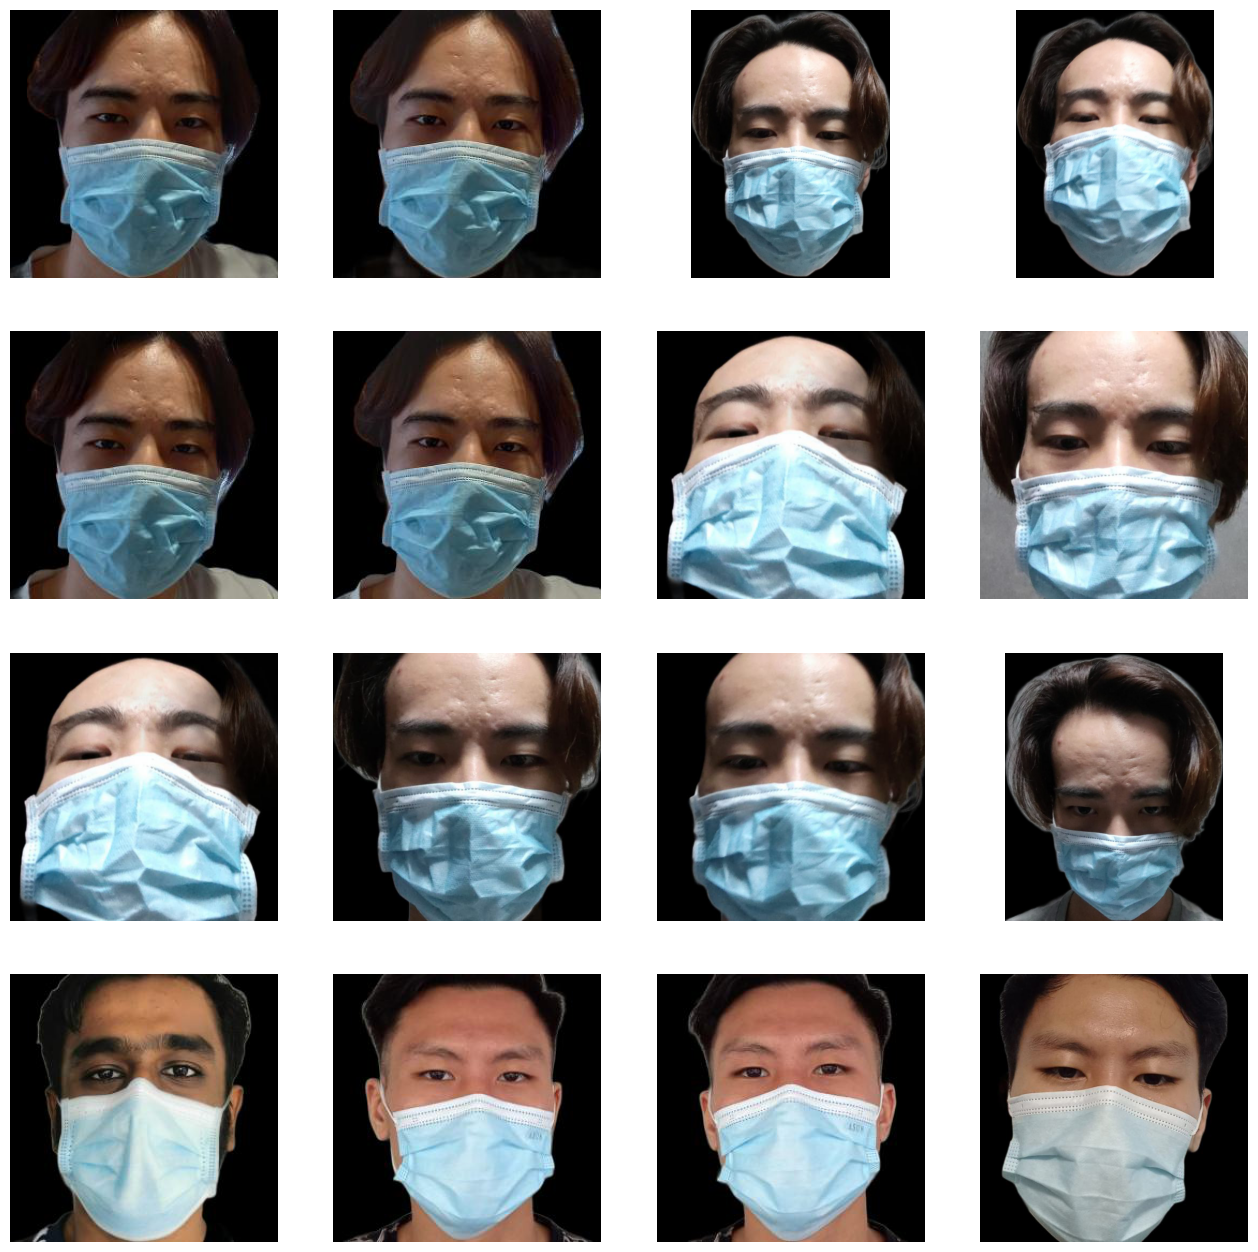

In [6]:
# Parameters for the graph; output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 16

next_face_pix = [fname for fname in face_fnames[pic_index-16:pic_index]]

for i, img_path in enumerate(next_face_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Testing

## Load Image

In [ ]:
from PIL import Image
from torchvision.transforms.functional import to_tensor
from utils import get_transform


img = Image.open(join(data_dir, face_fnames[2]))
plt.imshow(img)
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

## Query model and pass result through CRF

In [ ]:
import torch
import torch.nn.functional as F
from crf import dense_crf


with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

## Visualize Segmentation Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

In [ ]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes


fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(model.label_cmap[linear_pred])
ax[2].set_title("Linear Probe Predictions")
remove_axes(ax)

## Skin Segmentaion

In [ ]:
img_np = model.label_cmap[cluster_pred]

In [ ]:
plt.imshow(img_np)

In [ ]:
def my_func(a):
  return 1 if a[0] and a[1] and a[2] else 0

In [ ]:
import numpy as np


vals = np.array([0, 128, 128])
mask = np.apply_along_axis(my_func, -1, img_np == vals)
mask = np.expand_dims(mask, axis=-1)
ori_img = unnorm(img)[0].permute(1,2,0).cpu().detach().numpy()
skin = ori_img * mask

In [ ]:
plt.imshow(skin)

In [ ]:
output = Image.fromarray((skin * 255).astype(np.uint8))
output.save('test.jpg')

# Skin Segmentation

In [7]:
from utils import get_transform, unnorm
from crf import dense_crf


def and_op(a):
  return 1 if a[0] and a[1] and a[2] else 0

for fname in face_fnames:
  img = Image.open(fname)
  transform = get_transform(448, False, "center")
  img = transform(img).unsqueeze(0).cuda()

  with torch.no_grad():
    code1 = model(img)
    code2 = model(img.flip(dims=[3]))
    code = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
    #linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
    cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

    single_img = img[0].cpu()
    #linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
    cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

  img_np = model.label_cmap[cluster_pred]

  vals = np.array([0, 128, 128])
  skin_filter = np.apply_along_axis(and_op, -1, img_np == vals)
  skin_filter = np.expand_dims(skin_filter, axis=-1)
  ori_img = unnorm(img)[0].permute(1,2,0).cpu().detach().numpy()
  skin = ori_img * skin_filter

  output = Image.fromarray((skin * 255).astype(np.uint8))
  output.save(fname)

c:\Users\Admin\anaconda3\envs\eigenfaces\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 452.00 MiB (GPU 0; 2.00 GiB total capacity; 857.18 MiB already allocated; 0 bytes free; 1.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Parameters for the graph; output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 16

next_skin_pix = [join(processed_data_dir, fname) for fname in skin_fnames[pic_index-16:pic_index]]

for i, img_path in enumerate(next_skin_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()